In [48]:
import numpy as np
import pickle
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import random

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim

In [54]:
# Define the file paths
file_paths = ["index_history.pkl", "saved_indexes.pkl", "saved_symbols.pkl", "ticker_history.pkl", "event_clean.pkl"]

# Load the data from each file
data_dict = {}

for path in file_paths:
    with open(path, "rb") as file:
        data = pickle.load(file, encoding='latin1')
        data_dict[path] = data

# Access the loaded data
index_history = data_dict["index_history.pkl"]
saved_indices = data_dict["saved_indexes.pkl"]
saved_tickers = data_dict["saved_symbols.pkl"]
ticker_history = data_dict["ticker_history.pkl"]
event_history = data_dict["event_clean.pkl"]

# Print some information about the loaded data (optional)
print("Index History:", type(index_history), len(index_history))
print("Saved Indices:", type(saved_indices), len(saved_indices))
print("Saved Tickers:", type(saved_tickers), len(saved_tickers))
print("Ticker History:", type(ticker_history), len(ticker_history))
print("Earning History:", type(event_history), len(event_history))

Index History: <class 'dict'> 20
Saved Indices: <class 'list'> 20
Saved Tickers: <class 'list'> 101
Ticker History: <class 'dict'> 101
Earning History: <class 'dict'> 101


In [55]:
us_indices = ['^GSPC','^DJI','^IXIC','^NYA','^XAX','^RUT']
closing_time_from_midnight = pd.DateOffset(hours=16) # Closing time of NYSE(4pm). Closing time matters because we want
# to determine if the closing time is before or after event. # For pre-market earning events, 
# the 'before' data should not include the data from that day. 

closing_time_from_midnight_ind = {}
us_indices = ['^GSPC','^DJI','^IXIC','^NYA','^XAX','^RUT']
for ind in us_indices:
    closing_time_from_midnight_ind[ind] = pd.DateOffset(hours=16) # Closing time of NYSE
closing_time_from_midnight_ind['^VIX'] = pd.DateOffset(hours=15.25)
closing_time_from_midnight_ind['^BUK100P'] = pd.DateOffset(hours=17.5)
closing_time_from_midnight_ind['^FTSE'] = pd.DateOffset(hours=16.5)
closing_time_from_midnight_ind['^GDAXI'] = pd.DateOffset(hours=18)
closing_time_from_midnight_ind['^FCHI'] = pd.DateOffset(hours=17.5)
closing_time_from_midnight_ind['^STOXX50E'] = pd.DateOffset(hours=18)
closing_time_from_midnight_ind['^N100'] = pd.DateOffset(hours=17.5)
closing_time_from_midnight_ind['^BFX'] = pd.DateOffset(hours=17.5)
closing_time_from_midnight_ind['IMOEX.ME'] = pd.DateOffset(hours=16)
closing_time_from_midnight_ind['^N225'] = pd.DateOffset(hours=15)
closing_time_from_midnight_ind['^HSI'] = pd.DateOffset(hours=16)
closing_time_from_midnight_ind['000001.SS'] = pd.DateOffset(hours=15)
closing_time_from_midnight_ind['399001.SZ'] = pd.DateOffset(hours=15)
closing_time_from_midnight_ind['^STI'] = pd.DateOffset(hours=17)

In [67]:
# Using last num_days_before trading days. We dont care about when those days occured relative to each other
def earnings_data_no_of_trading_days(num_days_before,num_days_after):

    d = {}
    
    indices = saved_indices

    for sym in event_history:
        dum = []
        event_date = event_history[sym].index

        for j in range(len(event_history[sym])):
            dic = {"Before":0, "After":0, "Earning":0}
            dic['Earning'] = event_history[sym].iloc[[j]]

            ticker_closing = ticker_history[sym].index+closing_time_from_midnight
            dfb = ticker_history[sym][["Close"]][ticker_closing<=event_date[j]]
            dfb.sort_index(inplace=True)
            dfb = dfb[-num_days_before:]
            dfb = dfb.rename(columns = {"Close":sym})
            dfb.index = range(-len(dfb),0,1)
            for ind in indices:
                index_closing = index_history[ind].index+closing_time_from_midnight_ind[ind]
                dfbi = index_history[ind][["Close"]][index_closing<=event_date[j]]            
                dfbi.sort_index(inplace=True)
                dfbi = dfbi[-num_days_before:]
                dfbi = dfbi.rename(columns={"Close":ind})
                dfbi.index = range(-len(dfbi),0,1)
                dfb = dfb.join(dfbi)
            dic["Before"] = dfb

            ticker_closing = ticker_history[sym].index+closing_time_from_midnight
            dfa = ticker_history[sym][["Close"]][ticker_closing>event_date[j]]
            dfa.sort_index(inplace=True)
            dfa = dfa[:num_days_after]
            dfa = dfa.rename(columns = {"Close":sym})
            dfa.index = range(1,len(dfa)+1)
            for ind in indices:
                index_closing = index_history[ind].index+closing_time_from_midnight_ind[ind]
                dfai = index_history[ind][["Close"]][index_closing>event_date[j]]            
                dfai.sort_index(inplace=True)
                dfai = dfai[:num_days_after]
                dfai = dfai.rename(columns={"Close":ind})
                dfai.index = range(1,len(dfai)+1)
                dfa = dfa.join(dfai)
            dic["After"] = dfa

            dum.append(dic)
        d[sym] = dum
    return d

In [68]:
d = earnings_data_no_of_trading_days(30,7)

In [263]:
d['ADBE'][0]['Earning']

,EPS Estimate,Reported EPS,Surprise(%)
Earnings Date,,,
2023-12-13 16:00:00-05:00,4.14,4.27,0.0321


In [99]:
def check_df():
    cnt_1 = 0
    cnt_2 = 0
    for sym in d:
        for evt_idx in range(len(d[sym])):
            df_sym_idx = d[sym][evt_idx]
            
            ticker_b = df_sym_idx['Before'][sym].values
            
            index_b = df_sym_idx['Before']['^IXIC'].values

            surprise = df_sym_idx['Earning']['Surprise(%)'].values

            if len(ticker_b) != 30 or len(index_b) != 30:
                #print("{} - {} is not valid".format(sym, evt_idx))
                cnt_2 = cnt_2 + 1
            cnt_1 = cnt_1 + 1

    print('Total data-points = {}'.format(cnt_1))
    print('Valid data-points = {}'.format(cnt_1 - cnt_2))

In [100]:
check_df()

Total data-points = 1907
Valid data-points = 1719


In [242]:
def priced_in_label(ticker_0, ticker_a):
    r = ticker_a[-1]/ticker_0
    if r>1.0:
        return 1
    else:
        return 0

In [243]:
X=[]
Y=[]
Z=[]
tickers=[]
def generate_variables(df):
    for sym in df:
        for evt_idx in range(len(df[sym])):
            df_sym_idx = df[sym][evt_idx]
            
            ticker_b = df_sym_idx['Before'][sym].values
            index_b = df_sym_idx['Before']['^GSPC'].values
            ticker_a = df_sym_idx['After'][sym].values
            index_a = df_sym_idx['After']['^GSPC'].values
            
            
            if len(ticker_b) == 30 and len(index_b) == 30:
                ticker_0 = ticker_b[-1]
                index_0 = index_b[-1]
                
                ticker_b = np.log10(ticker_b/ticker_0)
                index_b = np.log10(index_b/index_0)
                
                surprise = df_sym_idx['Earning']['Surprise(%)'].values
                
                x = np.concatenate((ticker_b, index_b, surprise))
                y = priced_in_label(ticker_0, ticker_a)
                
                ticker_a = np.log10(ticker_a/ticker_0)
                index_a = np.log10(index_a/index_0)

                z = np.concatenate((ticker_a, index_a))
                X.append(x)
                Y.append(y)
                Z.append(z)
                tickers.append(sym)


In [244]:
generate_variables(d)

In [245]:
X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
tickers = np.array(tickers)

In [246]:
Z[0]

array([-0.02847698, -0.02844728, -0.01784444, -0.01386863, -0.02007554,
       -0.01711293, -0.01811999,  0.00114809,  0.00111497,  0.00307717,
        0.00561747, -0.00080711,  0.00364387,  0.00436423])

In [250]:
def plot_histories(save_fig=False):
    q = np.random.randint(X.shape[0])

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    ticker_ts = np.concatenate((X[q][:30], Z[q][:7]))
    index_ts = np.concatenate((X[q][30:60], Z[q][7:]))

    days=np.arange(1, 38, 1)
    ax.plot(days, ticker_ts, color='k', lw=1.0, label=tickers[q])
    ax.plot(days, index_ts, color='k', lw=0.5, ls='--', label='GSPC')
    ax.axvline(x=30, color='r', linestyle='-', linewidth=0.5, alpha=0.3)

    font_properties = FontProperties(family='serif', size=12)
    plt.legend(frameon=False, prop=font_properties)

    ax.text(0.85, 0.15, 'Y={}'.format(Y[q]), transform=ax.transAxes, verticalalignment='center', fontsize=14, fontfamily='serif', color='b')

    if save_fig:
        plt.savefig('history_views/{}_GSPC_history.png'.format(tickers[q]), dpi=300, bbox_inches='tight')

    plt.show()

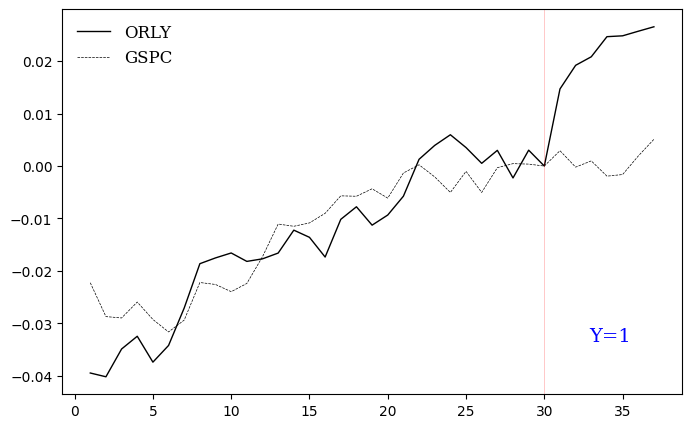

In [251]:
plot_histories(save_fig=True)

In [252]:
X = np.nan_to_num(X, nan=0)
Y = np.nan_to_num(Y, nan=0)

In [253]:
print(X.shape)
print(Y.shape)

(1719, 61)
(1719,)


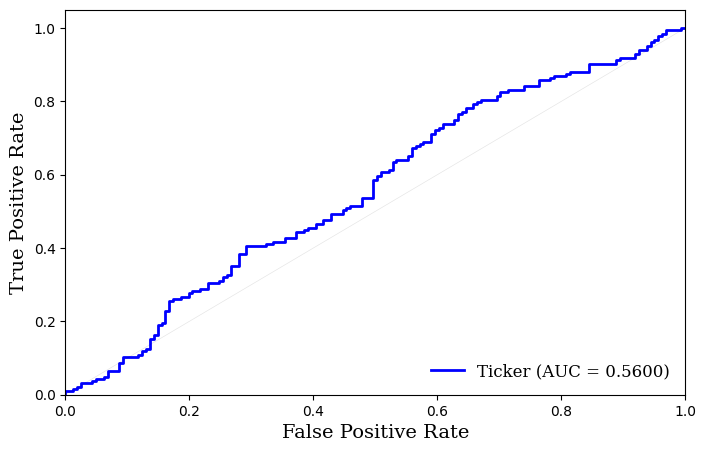

In [254]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=22)

logreg_model = LogisticRegression(solver='liblinear')
logreg_model.fit(X_train, y_train)

y_pred_prob_logreg = logreg_model.predict_proba(X_test)[:, 1]

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_prob_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

plt.figure(figsize=(8, 5))
plt.plot(fpr_logreg, tpr_logreg, color='blue', lw=2, label='Ticker (AUC = %0.4f)' % roc_auc_logreg)
plt.plot([0, 1], [0, 1], color='k', lw=0.5, linestyle='-', alpha=0.1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontfamily='serif')
plt.ylabel('True Positive Rate', fontsize=14, fontfamily='serif')

font_properties = FontProperties(family='serif', size=12)

plt.legend(loc='lower right', frameon=False, prop=font_properties)

plt.savefig('ticker_GSPC_result.png', dpi=300, bbox_inches='tight')

plt.show()

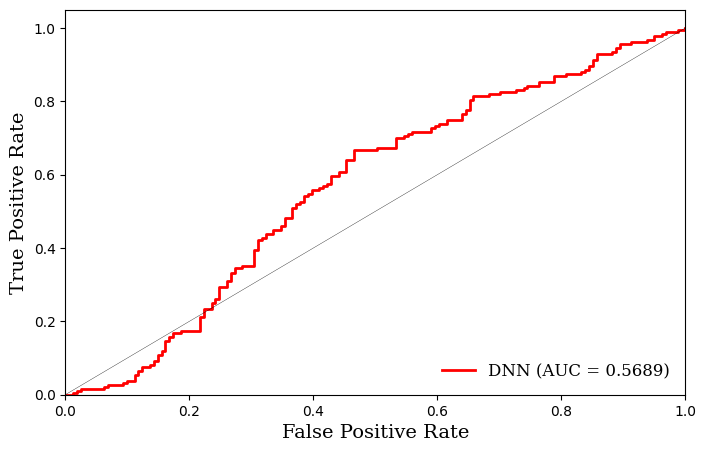

In [261]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Initialize and train the neural network
input_dim = X_train.shape[1]
model = SimpleNN(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Predict probabilities on the test set
model.eval()
with torch.no_grad():
    y_pred_prob_nn = model(X_test_tensor).numpy()

# Compute ROC curve and AUC for the neural network
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_prob_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

# Plot ROC curve for the neural network
plt.figure(figsize=(8, 5))
plt.plot(fpr_nn, tpr_nn, color='r', lw=2, label='DNN (AUC = %0.4f)' % roc_auc_nn)
plt.plot([0, 1], [0, 1], color='k', lw=0.25, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontfamily='serif')
plt.ylabel('True Positive Rate', fontsize=14, fontfamily='serif')
font_properties = FontProperties(family='serif', size=12)
plt.legend(loc='lower right', frameon=False, prop=font_properties)
plt.show()

In [256]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size * 2 + 1, hidden_size)  # X1 and X2 hidden states + scalar s
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, X1, s, X2):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, X1.size(0), self.hidden_size).to(X1.device)

        # RNN for X1
        out1, _ = self.rnn(X1, h0)
        out1 = out1[:, -1, :]  # take the last output from the sequence

        # RNN for X2
        out2, _ = self.rnn(X2, h0)
        out2 = out2[:, -1, :]  # take the last output from the sequence

        # Concatenate X1, s, and X2
        combined = torch.cat((out1, s, out2), dim=1)

        # Pass through fully connected layers
        out = torch.relu(self.fc1(combined))
        out = torch.sigmoid(self.fc2(out))  # Output between 0 and 1

        return out

In [259]:
input_size = 1  # Since each element in the time series is a scalar
hidden_size = 64
output_size = 1  # Since we're doing binary classification
num_layers = 1
learning_rate = 0.01
num_epochs = 1000

# Create the model, loss function, and optimizer
model = RNNModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Assuming X_train and Y_train are your training data
# X_train should be a tuple of (X1, s, X2)
# X1 and X2 are of shape (batch_size, sequence_length, input_size)
# s is of shape (batch_size, 1)
# Y_train is of shape (batch_size, 1)
X1_train, s_train, X2_train = (X_train[:, :30], X_train[:, 60], X_train[:, 30:60])
Y_train = torch.tensor(y_train, dtype=torch.float32)

# Training loop
for epoch in range(num_epochs):
    model.train()

    # Convert numpy arrays to torch tensors
    X1_train_tensor = torch.tensor(X1_train, dtype=torch.float32).unsqueeze(2)
    s_train_tensor = torch.tensor(s_train, dtype=torch.float32).unsqueeze(1)  # Make it (batch_size, 1)
    X2_train_tensor = torch.tensor(X2_train, dtype=torch.float32).unsqueeze(2)
    Y_train_tensor = Y_train.unsqueeze(1)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X1_train_tensor, s_train_tensor, X2_train_tensor)
    loss = criterion(outputs, Y_train_tensor)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [50/1000], Loss: 0.6746
Epoch [100/1000], Loss: 3.7536
Epoch [150/1000], Loss: 0.6786
Epoch [200/1000], Loss: 0.6773
Epoch [250/1000], Loss: 0.6765
Epoch [300/1000], Loss: 0.6758
Epoch [350/1000], Loss: 0.6753
Epoch [400/1000], Loss: 0.6750
Epoch [450/1000], Loss: 0.6747
Epoch [500/1000], Loss: 0.6746
Epoch [550/1000], Loss: 0.6745
Epoch [600/1000], Loss: 0.6744
Epoch [650/1000], Loss: 0.6743
Epoch [700/1000], Loss: 0.6742
Epoch [750/1000], Loss: 0.6741
Epoch [800/1000], Loss: 0.6740
Epoch [850/1000], Loss: 0.6739
Epoch [900/1000], Loss: 0.6737
Epoch [950/1000], Loss: 0.6736
Epoch [1000/1000], Loss: 0.6735


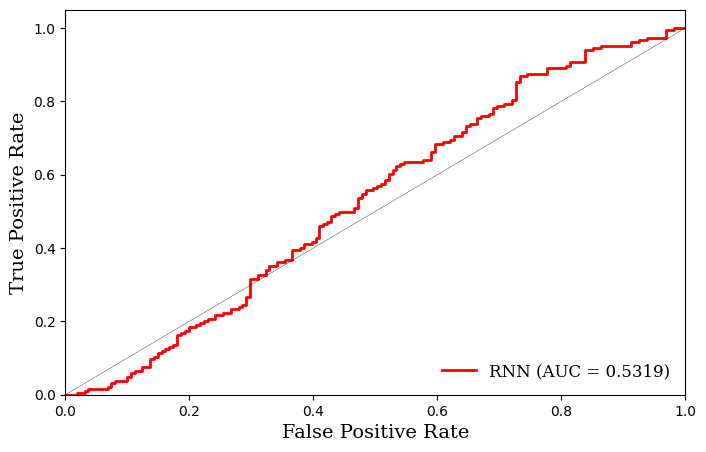

In [260]:
X1_test, s_test, X2_test = (X_test[:, :30], X_test[:, 60], X_test[:, 30:60])
Y_test = torch.tensor(y_test, dtype=torch.float32)

model.eval()
with torch.no_grad():
    X1_test_tensor = torch.tensor(X1_test, dtype=torch.float32).unsqueeze(2)
    s_test_tensor = torch.tensor(s_test, dtype=torch.float32).unsqueeze(1)  # Make it (batch_size, 1)
    X2_test_tensor = torch.tensor(X2_test, dtype=torch.float32).unsqueeze(2)
    Y_test_tensor = Y_test.unsqueeze(1)

    # Forward pass
    y_pred_prob_nn = model(X1_test_tensor, s_test_tensor, X2_test_tensor)

# Compute ROC curve and AUC for the neural network
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_prob_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

# Plot ROC curve for the neural network
plt.figure(figsize=(8, 5))
plt.plot(fpr_nn, tpr_nn, color='r', lw=2, label='RNN (AUC = %0.4f)' % roc_auc_nn)
plt.plot([0, 1], [0, 1], color='k', lw=0.25, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontfamily='serif')
plt.ylabel('True Positive Rate', fontsize=14, fontfamily='serif')
font_properties = FontProperties(family='serif', size=12)
plt.legend(loc='lower right', frameon=False, prop=font_properties)
plt.show()

In [224]:
Y_train_tensor.unsqueeze(1).shape

torch.Size([1375, 1])

In [53]:
# Define the function that adds log_returns, To Do: Turn this into a pre-processing class

def add_log_returns(df):
    if np.sum(df['Open'].isna().values) != 0:
        df['Open'].fillna(method='bfill', inplace=True)
    opens = df['Open'].values
    df['log_returns'] = np.log10(opens/opens[0])
    df['date'] = df.index.date

In [6]:
# Only AAPL has a NaN opening

for index in index_history:
    add_log_returns(index_history[index])
    

for ticker in ticker_history:
    add_log_returns(ticker_history[ticker])

In [7]:
# Double Check for missing values

for ticker in ticker_history:
    if ticker_history[ticker]['log_returns'][0] == np.nan:
        print(ticker)

for index in index_history:
    if index_history[index]['log_returns'][0] == np.nan:
        print(index)

In [8]:
# Store binary indicator for surprise

def add_surprise_label(df):
    df['s_label'] = df['Surprise(%)'].apply(lambda x: 1 if x > 0 else 0)

In [9]:
# Running the function

for ticker in earning_history:
    add_surprise_label(earning_history[ticker])

In [10]:
# Gathers 1_mo history(ies) of the ticker df1 given earnings data df2.

def gather_1mo_history(df1, df2):

    result = []
    for date in df2.index:
        start_date = date - pd.Timedelta(days=31)
        filtered_df1 = df1.loc[start_date:date]
        
        if len(filtered_df1) < 31:
            additional_rows_needed = 31 - len(filtered_df1)
            additional_rows = df1.loc[:start_date].tail(additional_rows_needed)
            filtered_df1 = pd.concat([additional_rows, filtered_df1])
        
        filtered_df1 = filtered_df1.iloc[-31:]
        
        open_values = filtered_df1['Open'].values
        result.append(open_values)
        
    result_df = pd.DataFrame(result, index=df2.index, columns=[f'X_{i+1}' for i in range(31)])
    result_df = result_df.dropna()
    result_df = np.log10(result_df.div(result_df.iloc[:, -1], axis=0))
    result_df = pd.merge(result_df, df2['s_label'], left_index=True, right_index=True, how='left')
    result_df.index = result_df.index.tz_convert('UTC')
    result_df.index = result_df.index.date 
    return result_df

In [11]:
# Given any two dfs, merge based on concurrent dates

def get_concurrent_prices(df1, df2):
    return pd.merge(df1, df2, on='date', how='inner', suffixes=('_1', '_2'))

# Plot correlations between histories

def check_correlation(df1, df2, plot=True, label1='X', label2='Y', color='b', name=None):
    df = get_concurrent_prices(df1, df2)
    correlation = df[['log_returns_1', 'log_returns_2']].corr().loc['log_returns_1', 'log_returns_2']

    fig, axes = plt.subplots(1, 1, figsize=(6, 4))

    sns.regplot(x='log_returns_1', y='log_returns_2', data=df, ax=axes, label='corr={:.2f}'.format(correlation), color=color, scatter_kws={'alpha':0.1, 's':15}, line_kws={'ls':'--', 'lw':1.5})
    axes.legend(frameon=False)
    axes.set_xlabel(label1, fontsize=12, fontfamily='serif')
    axes.set_ylabel(label2, fontsize=12, fontfamily='serif')
    plt.tight_layout()

    if name is not None:
        plt.savefig(name+'.png', dpi=300, bbox_inches='tight')

    plt.show()

In [12]:
# Get X, Y for our fitting

df_ixic=index_history['^IXIC']

def return_variables(ticker, include_index=True):
    df1=ticker_history[ticker]
    df2=earning_history[ticker]
    
    df_ticker=gather_1mo_history(df1, df2)

    if include_index:
        df_index=gather_1mo_history(df_ixic, df2)
        df = pd.merge(df_ticker, df_index, left_index=True, right_index=True)
        return df.iloc[:, list(range(0, 30)) + list(range(32, 62))].values, df['s_label_x'].values
    else:
        return df_ticker.iloc[:, :30].values, df_ticker['s_label'].values

In [13]:
# Calling the function over all tickers to generate data

for i, ticker in enumerate(ticker_history):
    x, y = return_variables(ticker, include_index=False)
    if i==0:
        X = x
        Y = y
    else:
        X = np.concatenate((X, x))
        Y = np.concatenate((Y, y))

for i, ticker in enumerate(ticker_history):
    x, y = return_variables(ticker)
    if i==0:
        X1 = x
        Y1 = y
    else:
        X1 = np.concatenate((X1, x))
        Y1 = np.concatenate((Y1, y))

In [14]:
Y = np.nan_to_num(Y, nan=0)
Y1 = np.nan_to_num(Y1, nan=0)

In [15]:
print(X.shape)
print(X1.shape)
print(Y.shape)

(1719, 30)
(1719, 60)
(1719,)


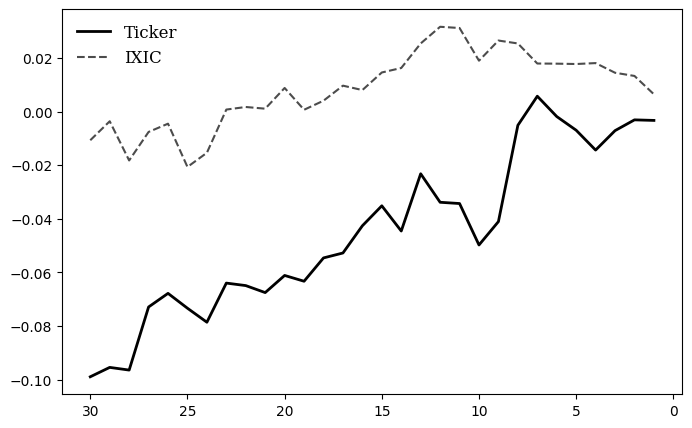

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i in range(1):
    q = np.random.randint(0, X1.shape[0])
    
    color = 'k'
    x11=X1[q, :30]
    x12=X1[q, 30:60]
    
    days=np.arange(30, 0, -1)
    
    ax.plot(days, x11, ls='-', lw=2.0, alpha=1.0, c=color, label='Ticker')
    ax.plot(days, x12, ls='--', lw=1.5, alpha=0.7, c=color, label='IXIC')
    ax.invert_xaxis()

font_properties = FontProperties(family='serif', size=12)
ax.legend(frameon=False, prop=font_properties)

plt.show()

In [32]:
np.arange(30, 0, -1)

array([30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14,
       13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

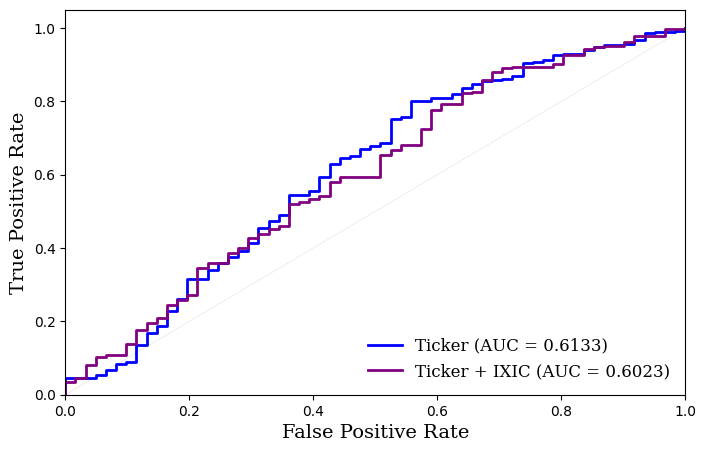

In [121]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

logreg_model = LogisticRegression(class_weight='balanced', solver='liblinear')
logreg_model.fit(X_train, y_train)

y_pred_prob_logreg = logreg_model.predict_proba(X_test)[:, 1]

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_prob_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)


X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size=0.2, random_state=42)

logreg_model1 = LogisticRegression(class_weight='balanced', solver='liblinear')
logreg_model1.fit(X_train1, y_train1)

y1_pred_prob_logreg = logreg_model1.predict_proba(X_test1)[:, 1]

fpr_logreg1, tpr_logreg1, _ = roc_curve(y_test1, y1_pred_prob_logreg)
roc_auc_logreg1 = auc(fpr_logreg1, tpr_logreg1)


plt.figure(figsize=(8, 5))
plt.plot(fpr_logreg, tpr_logreg, color='blue', lw=2, label='Ticker (AUC = %0.4f)' % roc_auc_logreg)
plt.plot(fpr_logreg1, tpr_logreg1, color='purple', lw=2, label='Ticker + IXIC (AUC = %0.4f)' % roc_auc_logreg1)
plt.plot([0, 1], [0, 1], color='k', lw=0.5, linestyle='-', alpha=0.1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontfamily='serif')
plt.ylabel('True Positive Rate', fontsize=14, fontfamily='serif')

font_properties = FontProperties(family='serif', size=12)

plt.legend(loc='lower right', frameon=False, prop=font_properties)

plt.savefig('ticker_IXIC_result.png', dpi=300, bbox_inches='tight')

plt.show()

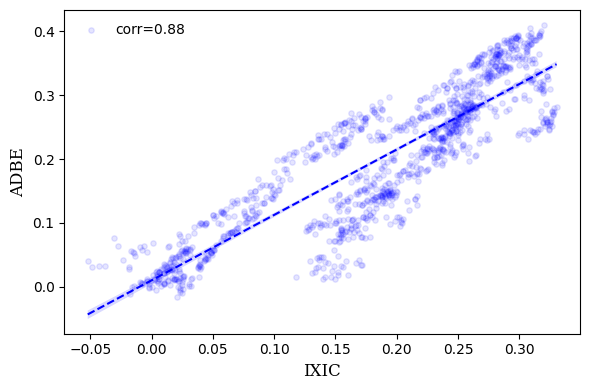

In [36]:
# Example on checking correlations

check_correlation(index_history['^IXIC'], ticker_history['ADBE'], label1='IXIC', label2='ADBE', name='ADBE_IXIC')

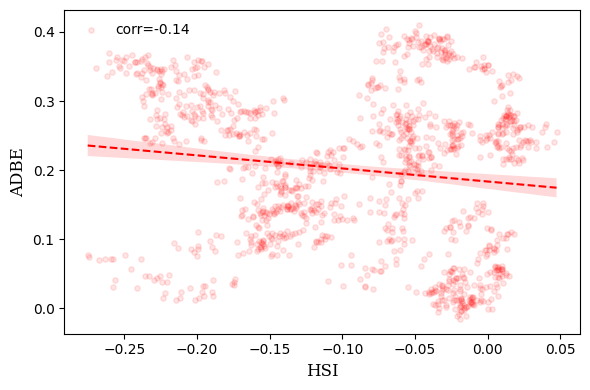

In [37]:
check_correlation(index_history['^HSI'], ticker_history['ADBE'], label1='HSI', label2='ADBE', color='r', name='ADBE_HSI')